# A basic example demonstraing difussion processes

By Emily Glover

## Step 1 - The forward direction

To understand the forward direction, consider a simple distribution for 1 pixel of the screen. NOTE: This is a vast simplification for what is happening but its good enough for now!

This pixel has a bimodal distribution which looks like the following:

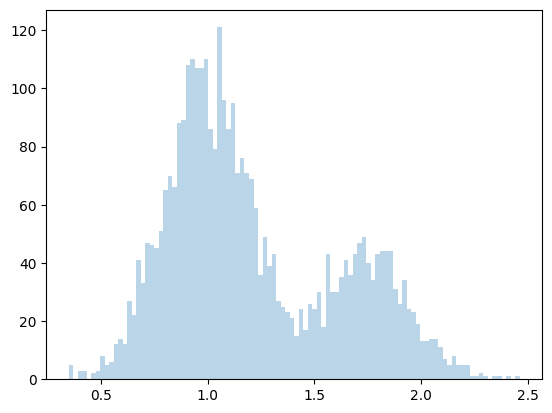

In [1]:
from pylab import *
from scipy.optimize import curve_fit

data=concatenate((normal(1,.2,2500),normal(1.75,.2,1000)))

y,x,_=hist(data,100,alpha=.3,label='data')

Fitting a curve to this distribution, we get something similar to the following:

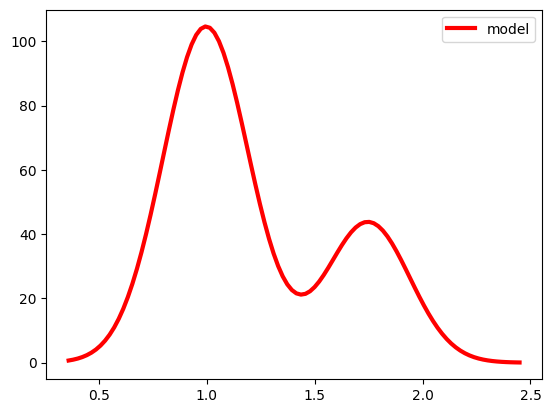

In [2]:
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)
def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected=(1,.2,250,1.75,.2,125)
params,cov=curve_fit(bimodal,x,y,expected)
sigma=sqrt(diag(cov))
plot(x,bimodal(x,*params),color='red',lw=3,label='model')
legend()

# Cite: https://stackoverflow.com/questions/35990467/fit-mixture-of-two-gaussian-normal-distributions-to-a-histogram-from-one-set-of


This curve serves as the starting point for our diffusion model. In a multidimensional version of this, the space could represent faces, animals or anything else. Lets go with this curve represents a dog. Any point sampled according to this particular distribution will somewhat represent a dog. 

The difussion process can be formulated according to the following equation:

$$\huge{ q(x_t|x_{t-1}) = \mathcal{N}(x_t ; \mu_t = \sqrt{1-\beta_t} x_{t-1} , \Sigma_t = \beta_t I)}$$

Essentially, to calculate $ q(x_t | x_{t-1})$, we sample from the above distribution, scale by $\beta_t$ and then add a bit of variance. Lets consider that we have a problem with T=15 time steps, then by the time we reach T=15, we should have total white noise i.e. a $\mathcal{N}(0,1)$ distribution.

For $x_1$ and $\beta_1$, the distribution becomes

$$\huge{ q(x_1|x_{0}) = \mathcal{N}(x_t ; \mu_t = \sqrt{1-\beta_1} x_{0} , \Sigma_t = \beta_1)}$$
$$\huge{ q(x_1|x_{0}) = \mathcal{N}(x_t ; \mu_t = \sqrt{1 - 0.06} x_{0} , \Sigma_t = 0.06)}$$
$$\huge{ q(x_1|x_{0}) = \mathcal{N}(x_t ; \mu_t = 0.97 x_{0} , \Sigma_t = 0.06)}$$

In this case, we scale the distribution down slightly by 0.03.
The graph of $q(x_1|x_0)$ is:

[0.9660917830792959, 0.9309493362512627, 0.8944271909999159, 0.8563488385776753, 0.816496580927726, 0.7745966692414834, 0.7302967433402214, 0.6831300510639732, 0.6324555320336759, 0.5773502691896258, 0.5163977794943223, 0.44721359549995787, 0.3651483716701107, 0.2581988897471611, 0.0]


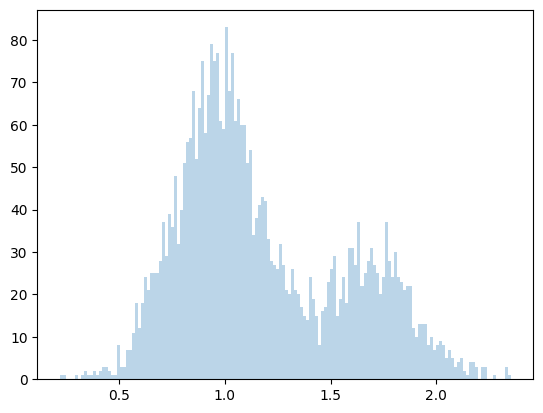

In [3]:
betas = [beta/15 for beta in range(1, 16)]
mean_scale = [sqrt(1 - beta) for beta in betas]
print(mean_scale)

q_x1 = data * mean_scale[0]

for i in range(0, len(q_x1)):
    
    if i == 0:
        data_q_x1=normal(q_x1[i],betas[0],1)
    else:
        data_q_x1=concatenate((data_q_x1,normal(q_x1[i],betas[0],1)))

y,x,_=hist(data_q_x1,150,alpha=.3,label='data')

# fig = plt.figure()
# ax1 = fig.add_subplot(2, 2, 1)
# ax2 = fig.add_subplot(2, 2, 2)
# n, bins, patches = ax1.hist(data_q_x1,100,alpha=.3,label='data')




Continuing reccursively, we get the following graphs:

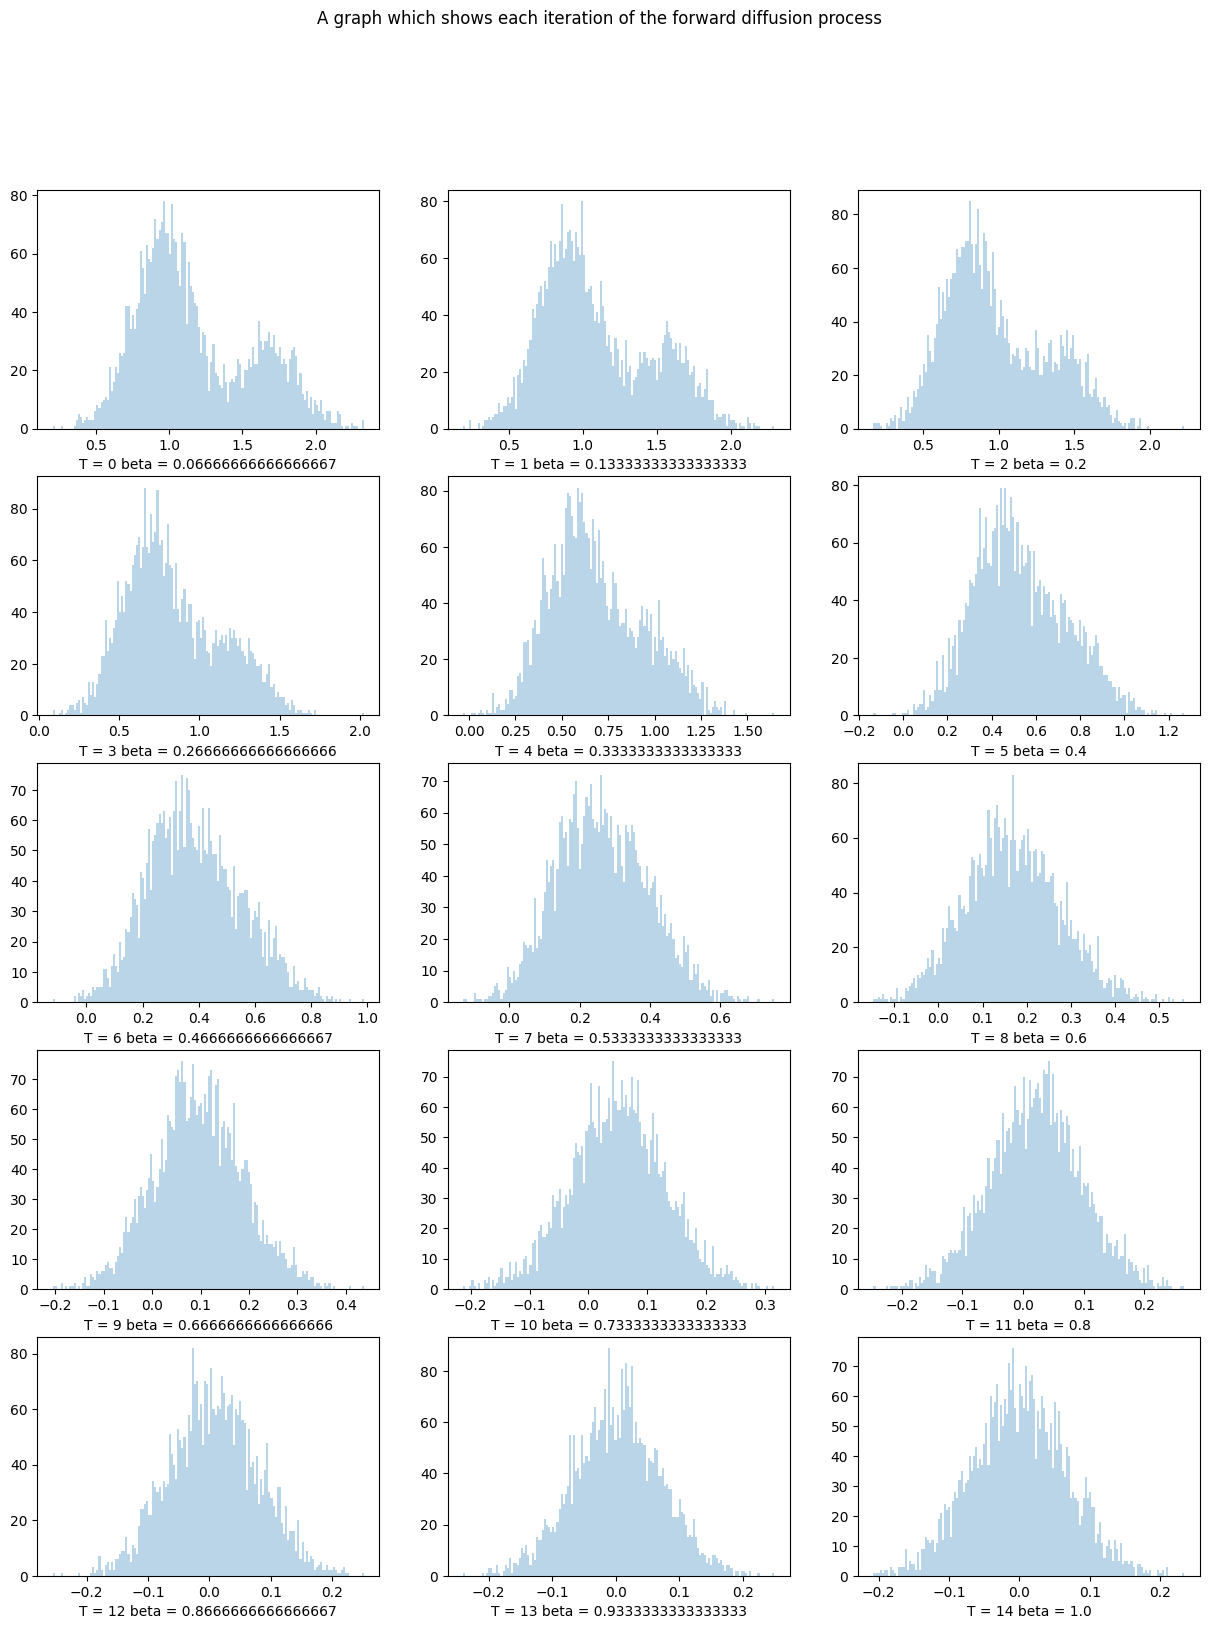

In [4]:
fig = plt.figure(figsize=(15, 18))
fig.suptitle("A graph which shows each iteration of the forward diffusion process")

for i in range(0,len(betas)):
    if i == 0:
        new_data = data * mean_scale[0]
    else:
        new_data = augmented_data * mean_scale[i]

    for j in range(0, len(new_data)):
        if j == 0:
            augmented_data=normal(new_data[j],betas[0],1)
        else:
            augmented_data=concatenate((augmented_data,normal(new_data[j],betas[0],1)))

    ax = fig.add_subplot(5, 3, i + 1)
    n, bins, patches = ax.hist(augmented_data,150,alpha=.3,label='data')
    ax.set_xlabel("T = " + str(i) + " beta = " + str(betas[i]))
    #y,x,_=hist(augmented_data,150,alpha=.3,label='data')


# q_x3 = data_q_x2 * mean_scale[2]

# for i in range(0, len(q_x3)):
    
#     if i == 0:
#         data_q_x3=normal(q_x3[i],betas[2],5)
#     else:
#         data_q_x3=concatenate((data_q_x3,normal(q_x3[i],betas[2],5)))

# y,x,_=hist(data_q_x3,250,alpha=.3,label='data')


At each iteration of this process, we are essentially saying "what if x is any value along the posterior curve and we resample that value according to a normal distribution with mean at x and some variance beta". In other words, we can track the distributions of x and beta throughout the problem and we get an output similar to the following:

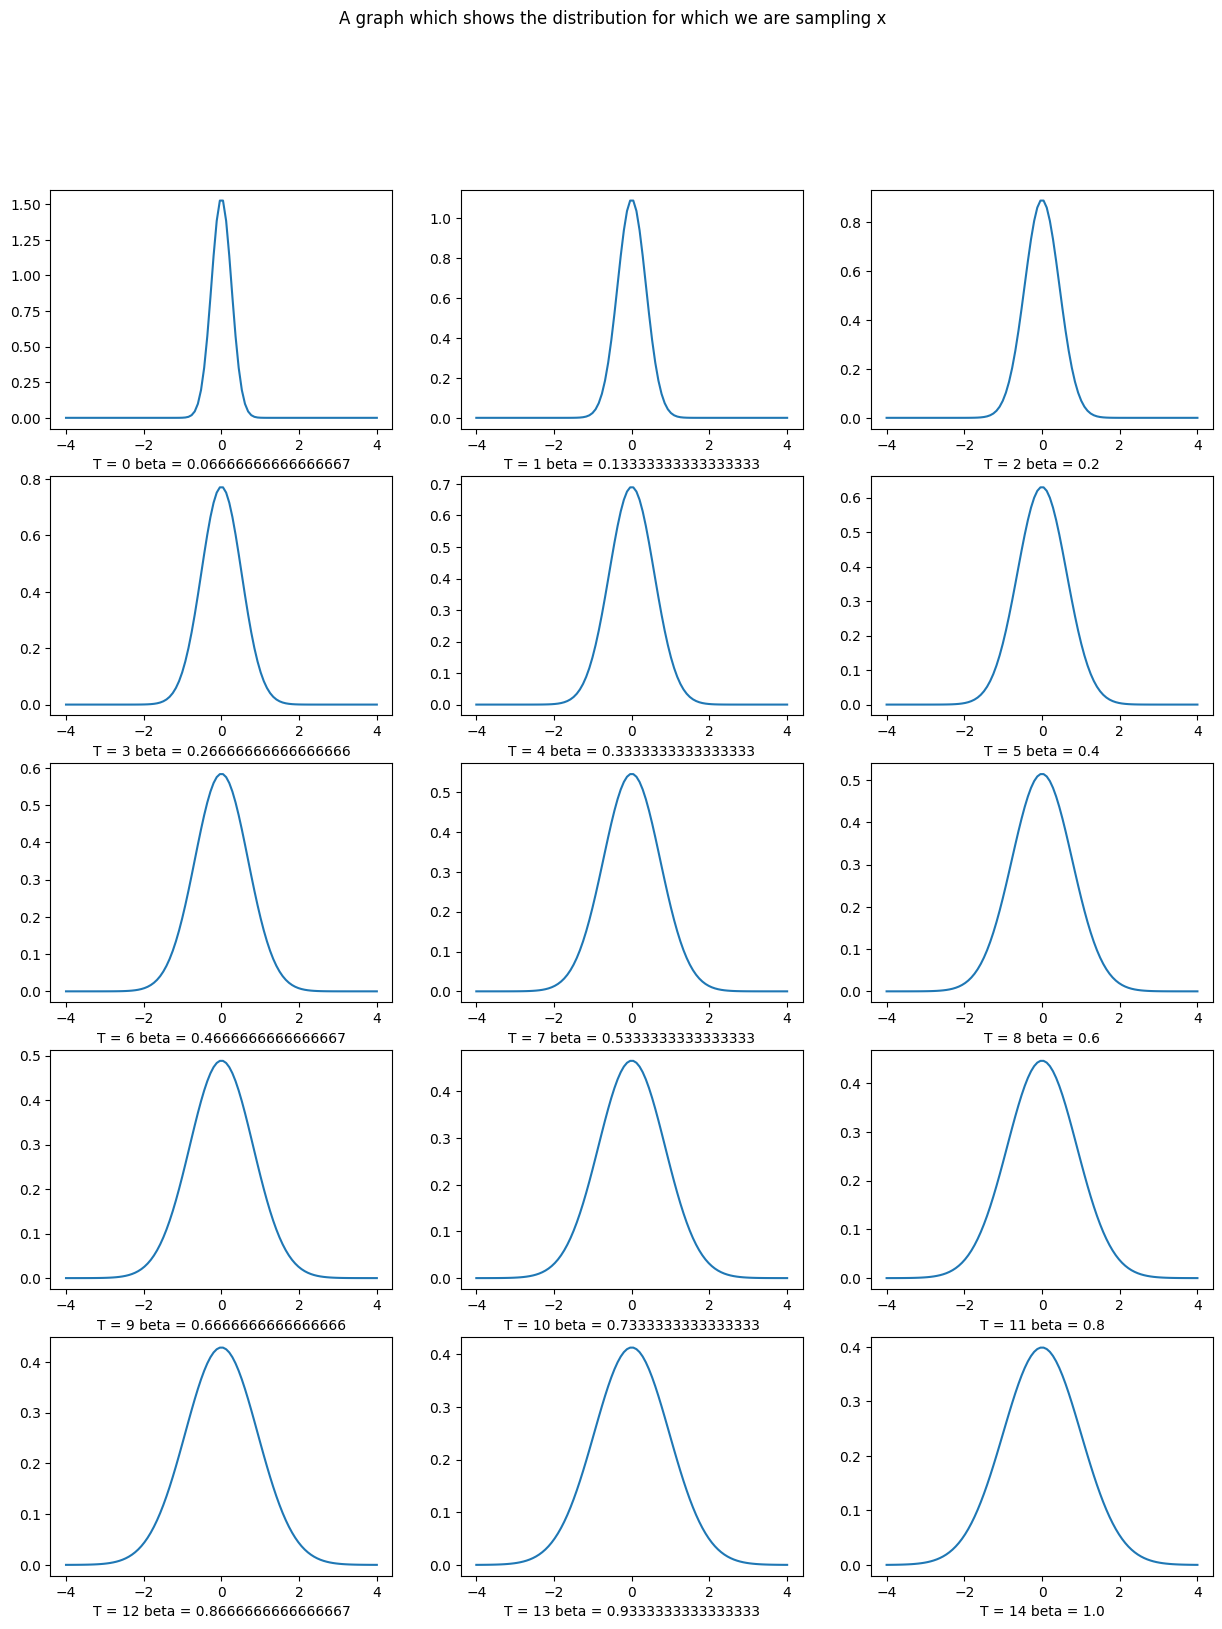

In [5]:
import scipy.stats as stats
import math

fig = plt.figure(figsize=(15, 18))
fig.suptitle("A graph which shows the distribution for which we are sampling x")

for i in range(0,len(betas)):

    mu = 0
    variance = betas[i]
    sigma = math.sqrt(variance)
    x = np.linspace(-4, 4, 100)
    ax = fig.add_subplot(5, 3, i + 1)
    n = ax.plot(x, stats.norm.pdf(x, mu, sigma))
    ax.set_xlabel("T = " + str(i) + " beta = " + str(betas[i]))




There exists an easier way to compute each of the posterior distributions without having to iterate throughout the whole problem. We can do this using the "reparameterisation trick":

$$\huge{ x_t \sim q(x_t | x_0) = \mathcal{N}(x_t ;  \sqrt{\hat{\alpha}_t} x_0 , (1 - \hat{\alpha}_t) I ) }$$

where $\alpha_t = 1 - \beta_t$ and $\hat{\alpha}_t = \prod_{s=0}^{t} \alpha_s$

## Step 2 - The backwards direction

To go in the backwards direction, we must approximate $q(x_{t-1}|x_t)$ because we don't have access to $q(x_{t-1})$. We use a parameterised model $p_\theta$ defined by the following:

$$\huge{p_\theta (x_{t-1}|x_t) = \mathcal{N}(x_{t-1} ; \mu_\theta(x_t,t), \Sigma_\theta (x_t,t))}$$

We can define it this way as a Gaussian distribution becase we intentionally set $q(x_{t}|x_{t-1})$ to be Gaussian in the forwards direction.